In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import losses,layers,metrics,optimizers,Sequential,activations,callbacks
from tensorflow.random import set_seed
from statsmodels.tsa.api import SARIMAX
from statsmodels.tools.eval_measures import mse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
#import statsmodels.api as stm
#import arch
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.stats import jarque_bera
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import ParameterSampler,ParameterGrid
from scipy.stats.distributions import uniform,binom,poisson,geom
from scipy.signal import periodogram
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
plt.rcParams['axes.edgecolor'] = '#ffffff'
plt.rcParams['axes.facecolor'] = '#ffffff'
plt.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['patch.edgecolor'] = '#ffffff'
plt.rcParams['patch.facecolor'] = '#ffffff'
plt.rcParams['savefig.edgecolor'] = '#ffffff'
plt.rcParams['savefig.facecolor'] = '#ffffff'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Visualización de la serie de tiempo 


/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


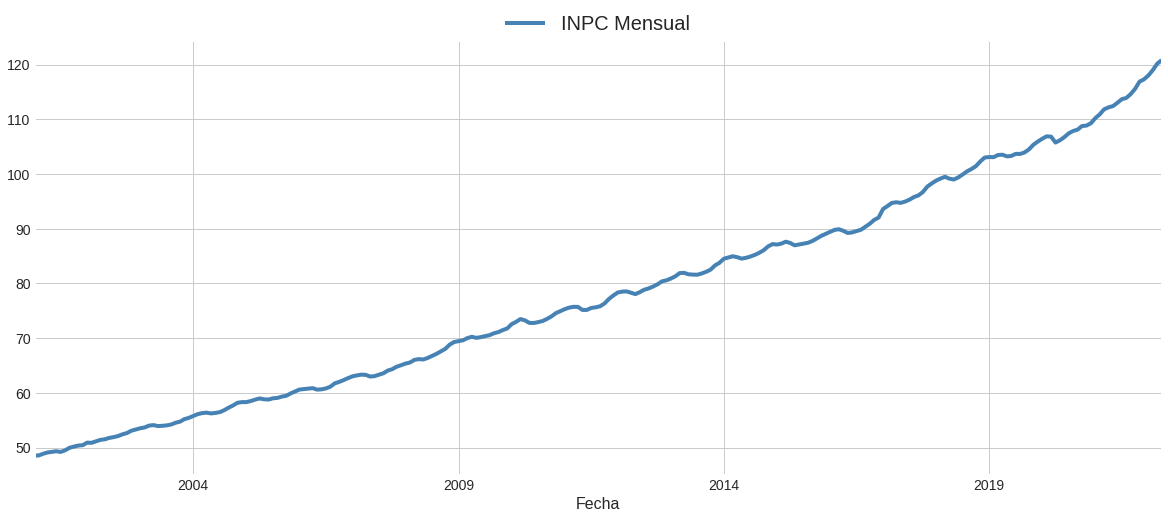

In [ ]:
INPC=pd.read_excel('https://raw.githubusercontent.com/Yael313255748/datasets/main/INPC.xlsx',header=17,usecols='A:B',index_col=0)
ind=INPC.index[INPC.index.year>=2001]
fig,ax=plt.subplots(1,1)
fig.set_figheight(8)
fig.set_figwidth(18)
(INPC.loc[ind,:]).plot(c='steelblue',ax=ax,legend=False)
ax.set_xlabel('Fecha',fontdict={'size':16})
ax.legend(['INPC Mensual'],loc='upper center',prop={'size': 20},bbox_to_anchor=(0.5, 1.1))
plt.savefig('INPC.png',dpi=100,format='png')
#plt.legend()
plt.show()

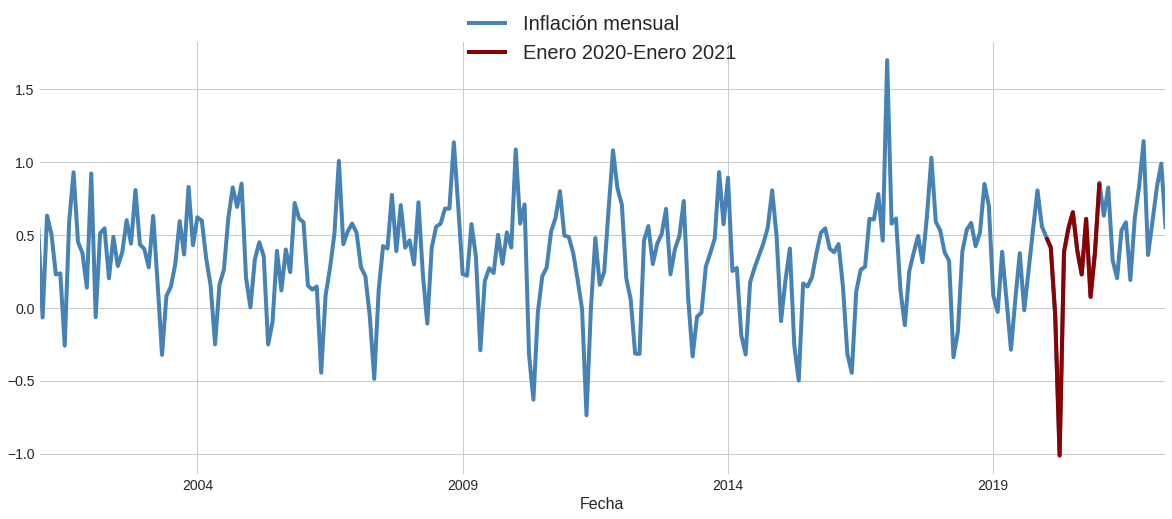

In [ ]:
#INPC['log(SP1)']=np.log(INPC['SP1'])
INPC.insert(1,'Inflación',np.repeat(np.nan,INPC.shape[0]))
#INPC.insert(2,'T(Inflación)',np.repeat(np.nan,INPC.shape[0]))
INPC.insert(2,'X_1t',np.repeat(np.nan,INPC.shape[0]))
INPC.insert(3,'X_12t',np.repeat(np.nan,INPC.shape[0]))

INPC['Inflación'].iloc[1:]=100*(INPC['SP1'].values[1:]/INPC['SP1'].values[:-1]-1)
#INPC['T(Inflación)'].iloc[1:]=100*(INPC['log(SP1)'].values[1:]/INPC['log(SP1)'].values[:-1]-1)
INPC['X_1t'].iloc[1:]=INPC['Inflación'].values[:-1]
INPC['X_12t'].iloc[12:]=INPC['Inflación'].values[:-12]


ind=INPC.index[INPC.index.year>=2001]
fig,ax=plt.subplots(1,1)
fig.set_figheight(8)
fig.set_figwidth(18)
(INPC.loc[ind,'Inflación']).plot(c='steelblue',ax=ax,legend=False)
(INPC.loc['2020-01-01':'2021-01-01','Inflación']).plot(c='darkred',ax=ax)
ax.set_xlabel('Fecha',fontdict={'size':16})
ax.legend(['Inflación mensual','Enero 2020-Enero 2021'],loc='upper center',prop={'size': 20},bbox_to_anchor=(0.5, 1.1))
plt.savefig('Infm.png',dpi=100,format='png')
plt.show()

# Coef. de correlación y autocorrelación parcial

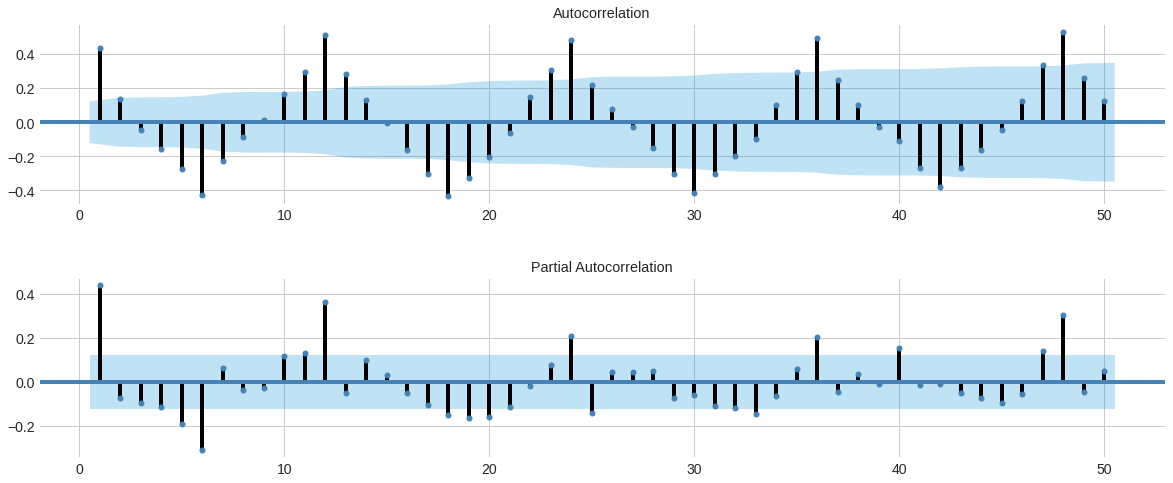

In [ ]:
lags=50
c='steelblue'
fig,ax=plt.subplots(2,1)
fig.subplots_adjust(hspace=0.4)
fig.set_figwidth(18)
fig.set_figheight(8)
plot_acf(INPC.loc[ind,'Inflación'].values[1:],zero=False,lags=lags,c=c,ax=fig.axes[0])
plot_pacf(INPC.loc[ind,'Inflación'].values[1:],zero=False,lags=lags,c=c,ax=fig.axes[1])
plt.savefig('ACF.png',dpi=100,format='png')
plt.show()


# Periodograma


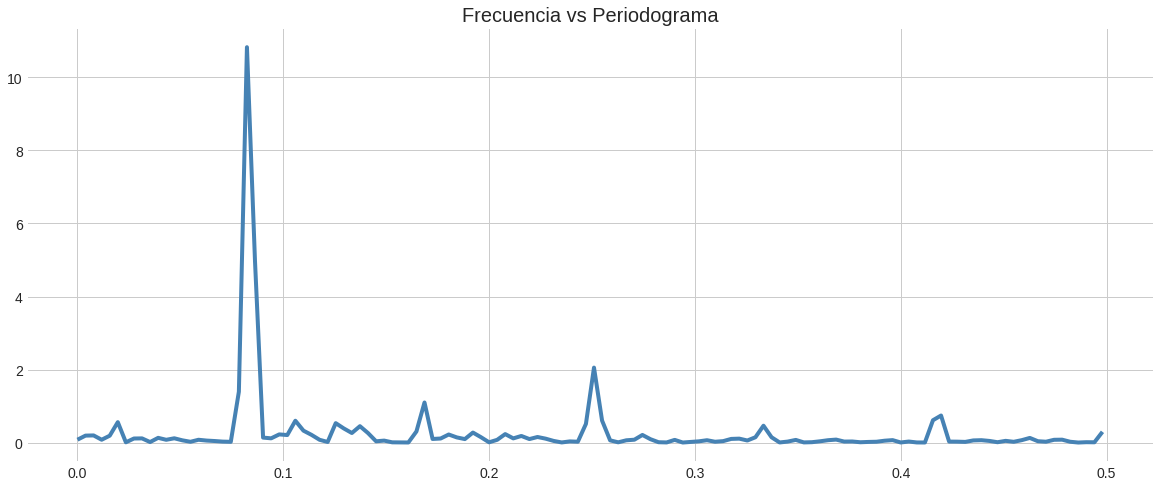

,Freqs(w),fs_est(w),Periodo
21,0.082353,10.828039,12.142857
22,0.086275,4.956283,11.590909


In [ ]:
freqs, density_est = periodogram(x=INPC.loc[ind,'Inflación'].values[1:], scaling='density', window='hamming')
df_fw_est = pd.DataFrame([freqs, density_est]).transpose()
df_fw_est.columns = ['Freqs(w)','fs_est(w)']
plt.figure(figsize=(18,8))
plt.plot(df_fw_est['Freqs(w)'],df_fw_est['fs_est(w)'],color='steelblue')
plt.savefig('Period.png',dpi=100,format='png')
plt.title('Frecuencia vs Periodograma',fontdict={'size':20})
plt.show()
df_fw_est['Periodo'] = 1/df_fw_est['Freqs(w)']
df_fw_est = df_fw_est.sort_values('fs_est(w)',ascending=False)
df_fw_est.head(2)

# Train and Test datasets


In [ ]:
data=INPC.loc[ind,:]
data['D(Inflación)']=data['Inflación'].diff(1)
data['X_1t']=data['D(Inflación)'].shift()
data['X_12t']=data['D(Inflación)'].shift(12)
s=round(data.shape[0]*0.8)
s='2020-12-01'
train=data.loc[:s,:]
test=data.loc[s:,:].iloc[1:,:]
X_t_train=train['D(Inflación)'].values[1:]
X_t_test=test['D(Inflación)'].values
adf_test=adfuller(data['Inflación'])
print(adf_test[1])
print(adfuller(data['D(Inflación)'].iloc[1:])[1])

0.1363026898363897
8.261598923003639e-17


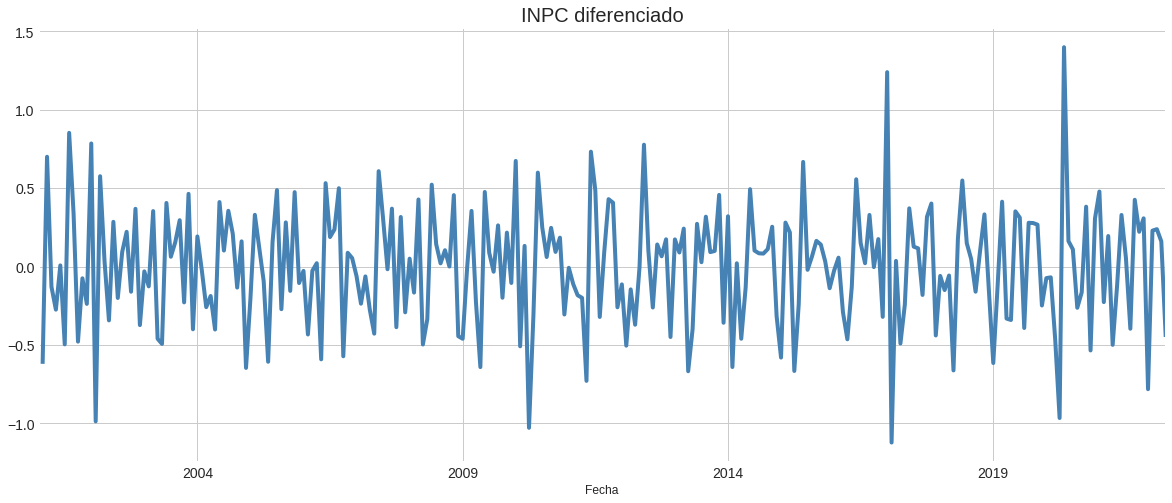

In [ ]:
data['D(Inflación)'].plot(figsize=(18,8),color='steelblue')
plt.title('INPC diferenciado',fontdict={'size':20})
plt.show()

# SARIMA


In [ ]:
sarima_models=[]

orders=[(1,0,0),(1,0,1),(0,0,0)]

sea_ord=[(1,0,0,12),(1,0,1,12)]

params=list(ParameterGrid({'order':orders,'seasonal_order':sea_ord}))

S=len(X_t_train)
k=len(X_t_test)

data_sarima=pd.DataFrame(np.zeros((len(params),5)),columns=['order','seasonal_order','AIC','test_mse','train_mse'])

j=0

for par in params:
  sarima=SARIMAX(X_t_train,order=par['order'],seasonal_order=par['seasonal_order']).fit()
  sarima_models.append(sarima)
  x_predict=sarima.forecast(steps=k)
  MSE=mse(X_t_test,x_predict)
  MSE2=mse(X_t_train,sarima.fittedvalues)
  data_sarima.iloc[j,0]=str(par['order'])
  data_sarima.iloc[j,1]=str(par['seasonal_order'])
  data_sarima.iloc[j,2]=sarima.aic
  data_sarima.iloc[j,3]=MSE
  data_sarima.iloc[j,4]=MSE2
  # data_sarima.iloc[j,4]=MAPE
  j+=1
  # print('SARIMA({})x({}), test_mse: {:.4f}, test_mae: {:.4f}, test_mape: {:.4f}\n'.format(par['order'],par['seasonal_order'],
  #                                                                                         MSE,MAE,MAPE))
  print('SARIMA({})x({}), AIC: {:.4f},test_mse: {:.4f}, train_mse: {:.4f}\n'.format(par['order'],par['seasonal_order'],sarima.aic,MSE,MSE2))
  #print(sarima.summary())
  print('----------------------------------------------------\n')

SARIMA((1, 0, 0))x((1, 0, 0, 12)), AIC: 149.4270,test_mse: 0.1958, train_mse: 0.1078

----------------------------------------------------

SARIMA((1, 0, 0))x((1, 0, 1, 12)), AIC: 106.4149,test_mse: 0.1026, train_mse: 0.0900

----------------------------------------------------



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA((1, 0, 1))x((1, 0, 0, 12)), AIC: 74.0305,test_mse: 0.1946, train_mse: 0.0782

----------------------------------------------------

SARIMA((1, 0, 1))x((1, 0, 1, 12)), AIC: 25.3986,test_mse: 0.0822, train_mse: 0.0639

----------------------------------------------------

SARIMA((0, 0, 0))x((1, 0, 0, 12)), AIC: 162.5911,test_mse: 0.1854, train_mse: 0.1151

----------------------------------------------------

SARIMA((0, 0, 0))x((1, 0, 1, 12)), AIC: 124.9601,test_mse: 0.0906, train_mse: 0.0984

----------------------------------------------------



In [ ]:
data_sarima.sort_values('AIC')

,order,seasonal_order,AIC,test_mse,train_mse
3,"(1, 0, 1)","(1, 0, 1, 12)",25.398640,0.082191,0.063851
2,"(1, 0, 1)","(1, 0, 0, 12)",74.030454,0.194630,0.078245
1,"(1, 0, 0)","(1, 0, 1, 12)",106.414945,0.102642,0.089999
5,"(0, 0, 0)","(1, 0, 1, 12)",124.960120,0.090591,0.098361
0,"(1, 0, 0)","(1, 0, 0, 12)",149.427024,0.195795,0.107844
4,"(0, 0, 0)","(1, 0, 0, 12)",162.591144,0.185444,0.115109


In [ ]:
sarima_models[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  239
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                  -7.699
Date:                            Wed, 08 Jun 2022   AIC                             25.399
Time:                                    17:24:50   BIC                             42.781
Sample:                                         0   HQIC                            32.403
                                            - 239                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2856      0.071      4.037      0.000       0.147       0.424
ma.L1         -0.9991      0.040    -24.765      0.000      -1.078      -0.920
ar.S.L12       0.9693      0.023     41.270      0.000       0.923       1.015
ma.S.L12      -0.7551      0.083     -9.151      0.000      -0.917      -0.593
sigma2         0.0589      0.005     12.995      0.000       0.050       0.068
===================================================================================
Ljung-Box (Q):                       37.28   Jarque-Bera (JB):               162.61
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             0.37
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
data_predictions=data[['Inflación','D(Inflación)']].copy()
data_predictions['sarima_Dpredictions']=np.nan
data_predictions['sarima_predictions']=np.nan
data_predictions['sarima_conf_dint_l']=np.nan
data_predictions['sarima_conf_dint_u']=np.nan
data_predictions['sarima_conf_int_l']=np.nan
data_predictions['sarima_conf_int_u']=np.nan

data_predictions['sarima_Dpredictions'].iloc[1:]=sarima_models[3].predict(0,S+k-1)
confidence_intervals=sarima_models[3].get_prediction(0,S+k-1).conf_int(alpha=0.05)
data_predictions['sarima_conf_dint_l'].iloc[1:]=confidence_intervals[:,0]
data_predictions['sarima_conf_dint_u'].iloc[1:]=confidence_intervals[:,1]

for i in range(data_predictions.shape[0]-1):
  data_predictions['sarima_predictions'].iloc[i+1]=data_predictions['sarima_Dpredictions'].iloc[i+1]+data_predictions['Inflación'].iloc[i]
  data_predictions['sarima_conf_int_l'].iloc[i+1]=data_predictions['sarima_conf_dint_l'].iloc[i+1]+data_predictions['Inflación'].iloc[i]
  data_predictions['sarima_conf_int_u'].iloc[i+1]=data_predictions['sarima_conf_dint_u'].iloc[i+1]+data_predictions['Inflación'].iloc[i]

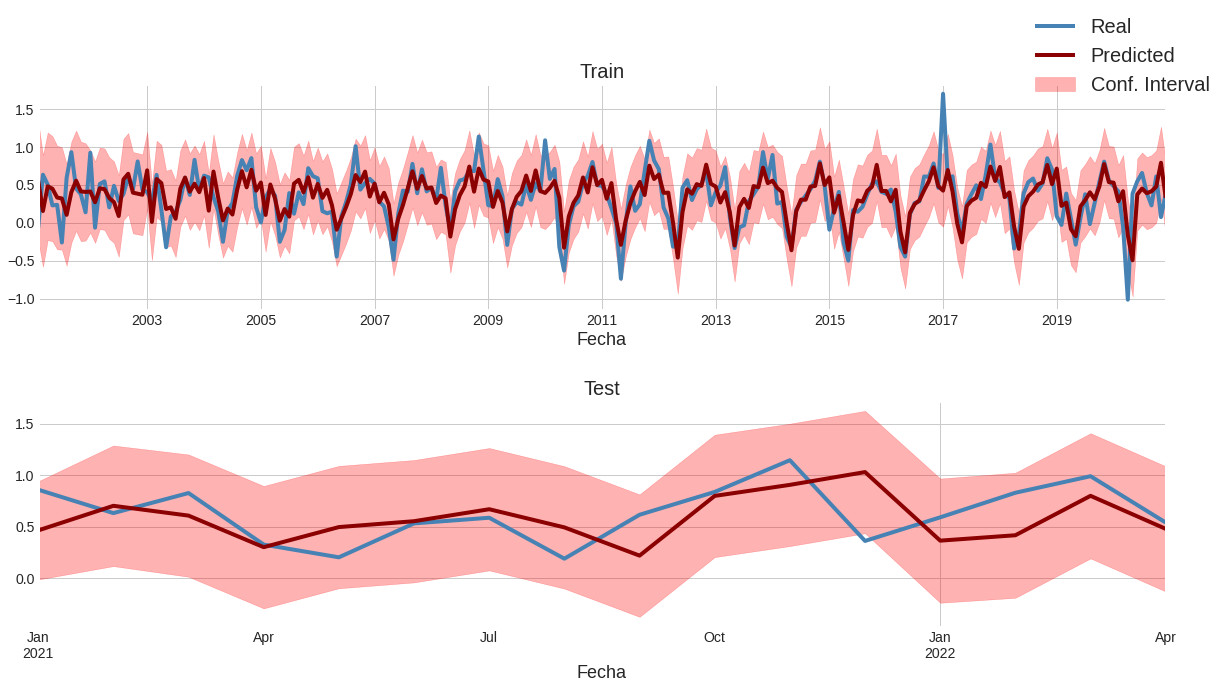

In [ ]:
# train_conf_intervals=sarima_models[3].get_prediction(0,S-1).conf_int(alpha=0.05)
# test_conf_intervals=sarima_models[3].get_forecast(steps=k).conf_int(alpha=0.05)
fig,ax=plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(18)
fig.subplots_adjust(hspace=0.4)
data_predictions[['Inflación','sarima_predictions']].iloc[1:S+1,:].plot(color=['steelblue','darkred'],ax=ax[0],legend=False)
ax[0].fill_between(data_predictions.iloc[:S+1,:].index,data_predictions['sarima_conf_int_l'].iloc[:S+1], data_predictions['sarima_conf_int_u'].iloc[:S+1], alpha=0.3,color='r')
ax[0].set_title('Train',fontsize=20)
ax[0].set_xlabel('Fecha',fontsize=18)
data_predictions[['Inflación','sarima_predictions']].iloc[S+1:,:].plot(color=['steelblue','darkred'],ax=ax[1],legend=False)
ax[1].fill_between(data_predictions.iloc[S+1:,:].index,data_predictions['sarima_conf_int_l'].iloc[S+1:], data_predictions['sarima_conf_int_u'].iloc[S+1:], alpha=0.3,color='r')
ax[1].set_title('Test',fontsize=20)
ax[1].set_xlabel('Fecha',fontsize=18)
#plt.title('MSE: {:.4f}'.format(mse(test_predictions['Inflación'].values,test_predictions['Predict SARIMA'].values))
#,fontdict={'size':16})
#ax.set_xlabel('Fecha',fontdict={'size':16})
#ax.legend(['Real','Predicted'],loc='upper center',prop={'size': 20},bbox_to_anchor=(0.1, 1.1))
fig.legend(['Real','Predicted','Conf. Interval'],loc='upper right',prop={'size': 20})
plt.savefig('sarima_fore.png',dpi=100,format='png')
plt.show()

In [ ]:
print('train_mse: ',mse(data_predictions[['Inflación']].iloc[1:S+1,:].values,data_predictions[['sarima_predictions']].iloc[1:S+1,:].values))
print('test_mse',mse(data_predictions[['Inflación']].iloc[S+1:,:].values,data_predictions[['sarima_predictions']].iloc[S+1:,:].values))

train_mse:  [0.06385116]
test_mse [0.08219067]


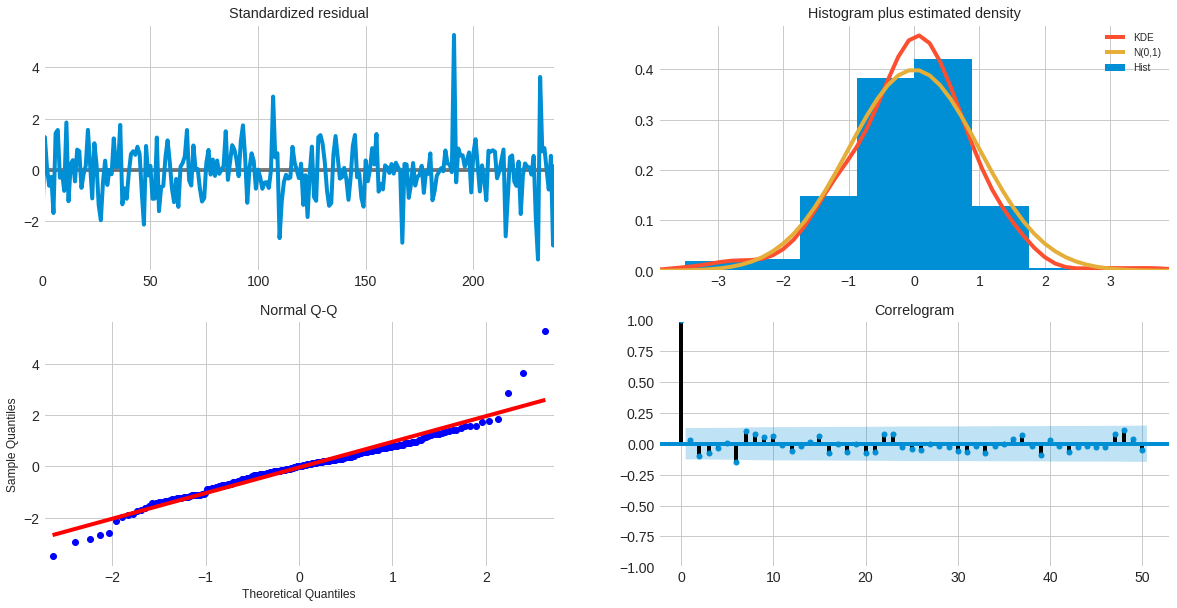

In [ ]:
sarima_models[3].plot_diagnostics(lags=50,figsize=(18,10))
plt.show()

# Holt Winters


In [ ]:
holtwinters_models=[]
# alpha=np.arange(0.05,0.1,0.05)
# beta=np.arange(0.05,0.1,0.05)
# gamma=np.arange(0.05,0.1,0.05)
params=list(ParameterSampler({'alpha':uniform(0,0.1),'beta':uniform(0,0.1),'gamma':uniform(0,0.1)},n_iter=50,random_state=100))
# S=len(X_t_train)
# k=data.shape[0]-S
data_hold_winter=pd.DataFrame(np.zeros((50,5)),columns=['alpha','beta','gamma','test_mse','train_mse'])
j=0
for par in params:
  holtwinters=ExponentialSmoothing(X_t_train,seasonal_periods=12,trend='add',seasonal='add').fit(par['alpha'],par['beta'],par['gamma'])
  holtwinters_models.append(holtwinters)
  x_predict=holtwinters.forecast(steps=k)
  MSE=mse(X_t_test,x_predict)
  MSE2=mse(X_t_train,holtwinters.fittedvalues)

  data_hold_winter.iloc[j,:3]=np.array([par['alpha'],par['beta'],par['gamma']])
  data_hold_winter.iloc[j,3]=MSE
  data_hold_winter.iloc[j,4]=MSE2
  j+=1
  print('Holt-Winters(alpha= {:.4f},beta= {:.4f},gamma= {:.4f}), test_mse: {:.4f}, train_mse: {:.4f}\n'.format(par['alpha'],par['beta'],par['gamma'],MSE,MSE2))
  #print(sarima.summary())
  print('----------------------------------------------------\n')

Holt-Winters(alpha= 0.0543,beta= 0.0278,gamma= 0.0425), test_mse: 0.0663, train_mse: 0.0944

----------------------------------------------------

Holt-Winters(alpha= 0.0845,beta= 0.0005,gamma= 0.0122), test_mse: 0.0678, train_mse: 0.0954

----------------------------------------------------

Holt-Winters(alpha= 0.0671,beta= 0.0826,gamma= 0.0137), test_mse: 0.2086, train_mse: 0.2790

----------------------------------------------------

Holt-Winters(alpha= 0.0575,beta= 0.0891,gamma= 0.0209), test_mse: 0.1704, train_mse: 0.2551

----------------------------------------------------

Holt-Winters(alpha= 0.0185,beta= 0.0108,gamma= 0.0220), test_mse: 0.0672, train_mse: 0.0901

----------------------------------------------------

Holt-Winters(alpha= 0.0979,beta= 0.0812,gamma= 0.0172), test_mse: 0.0675, train_mse: 0.0980

----------------------------------------------------

Holt-Winters(alpha= 0.0816,beta= 0.0274,gamma= 0.0432), test_mse: 0.0662, train_mse: 0.0970

-------------------------

In [ ]:
data_hold_winter.sort_values('test_mse').head()

,alpha,beta,gamma,test_mse,train_mse
27,0.008846,0.052804,0.099216,0.063746,0.148712
12,0.098092,0.005994,0.089055,0.064806,0.098723
11,0.038194,0.003648,0.089041,0.064866,0.093202
28,0.039504,0.033560,0.080545,0.065070,0.093489
34,0.061033,0.030900,0.069773,0.065232,0.095497


In [ ]:
data_predictions2=data[['Inflación','D(Inflación)']].copy()
data_predictions2['sarima_Dpredictions']=np.nan
data_predictions2['sarima_predictions']=np.nan


data_predictions2['sarima_Dpredictions'].iloc[1:]=holtwinters_models[12].predict(0,S+k-1)


for i in range(data_predictions2.shape[0]-1):
  data_predictions2['sarima_predictions'].iloc[i+1]=data_predictions2['sarima_Dpredictions'].iloc[i+1]+data_predictions2['Inflación'].iloc[i]

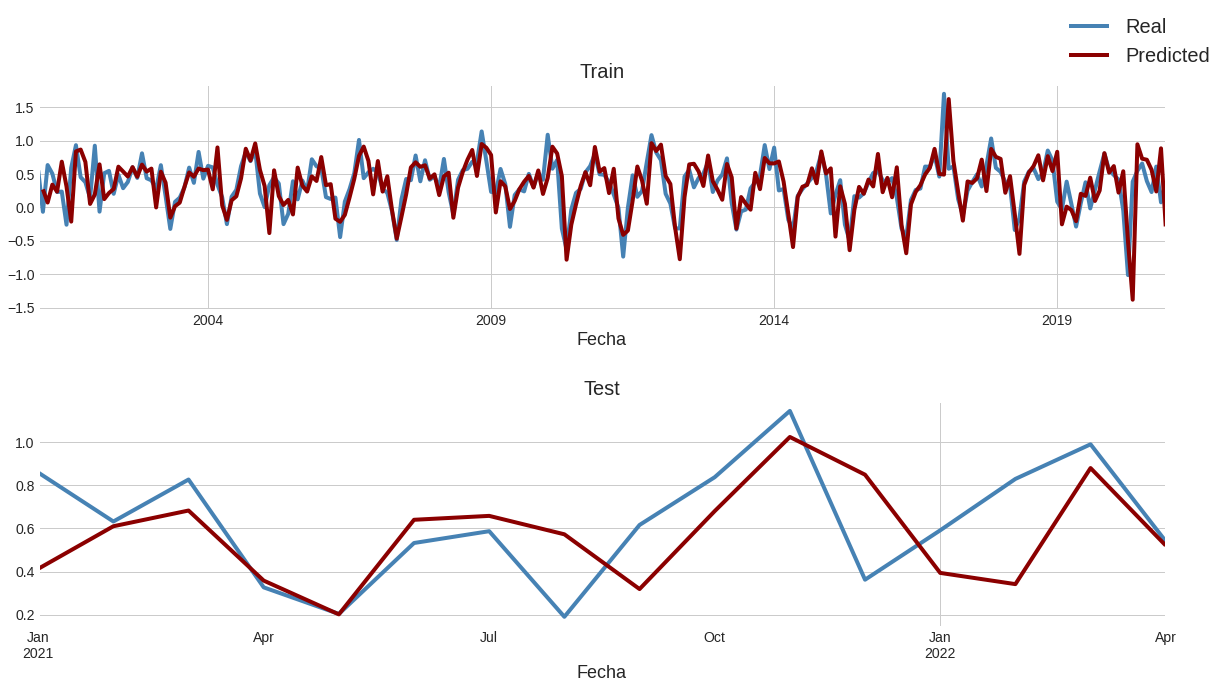

In [ ]:
fig,ax=plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(18)
fig.subplots_adjust(hspace=0.4)
data_predictions2[['Inflación','sarima_predictions']].iloc[:S+1,:].plot(color=['steelblue','darkred'],ax=ax[0],legend=False)
#ax[0].fill_between(data_predictions2.iloc[:S+1,:].index,data_predictions2['sarima_conf_int_l'].iloc[:S+1], data_predictions2['sarima_conf_int_u'].iloc[:S+1], alpha=0.3,color='r')
ax[0].set_title('Train',fontsize=20)
ax[0].set_xlabel('Fecha',fontsize=18)
data_predictions2[['Inflación','sarima_predictions']].iloc[S+1:,:].plot(color=['steelblue','darkred'],ax=ax[1],legend=False)
#ax[1].fill_between(data_predictions.iloc[S+1:,:].index,data_predictions2['sarima_conf_int_l'].iloc[S+1:], data_predictions2['sarima_conf_int_u'].iloc[S+1:], alpha=0.3,color='r')
ax[1].set_title('Test',fontsize=20)
ax[1].set_xlabel('Fecha',fontsize=18)
#plt.title('MSE: {:.4f}'.format(mse(test_predictions['Inflación'].values,test_predictions['Predict SARIMA'].values))
#,fontdict={'size':16})
#ax.set_xlabel('Fecha',fontdict={'size':16})
#ax.legend(['Real','Predicted'],loc='upper center',prop={'size': 20},bbox_to_anchor=(0.1, 1.1))
fig.legend(['Real','Predicted'],loc='upper right',prop={'size': 20})
plt.savefig('sarima_fore.png',dpi=100,format='png')
plt.show()

In [ ]:
print('train_mse: ',mse(data_predictions2[['Inflación']].iloc[1:S+1,:].values,data_predictions2[['sarima_predictions']].iloc[1:S+1,:].values))
print('test_mse',mse(data_predictions2[['Inflación']].iloc[S+1:,:].values,data_predictions2[['sarima_predictions']].iloc[S+1:,:].values))

train_mse:  [0.09872275]
test_mse [0.06480569]


# Neural Network

In [ ]:
train['mes']=train.index.month
test['mes']=test.index.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test=pd.get_dummies(test,columns=['mes'],drop_first=True)
train=pd.get_dummies(train,columns=['mes'],drop_first=True)

In [ ]:
train.iloc[12:,:]

In [ ]:
X_train=train.iloc[:,[2,3,5,6,7,8,9,10,11,12,13,14,15]].values[13:,:]
X_test=test.iloc[:,[2,3,5,6,7,8,9,10,11,12,13,14,15]].values
y_train=train['D(Inflación)'].values[13:S+1]
y_test=test['D(Inflación)'].values
# X_train=train.loc[:,['X_12t']].values
# X_test=test.loc[:,['X_12t']].values
# y_train=train['Inflación'].values
# y_test=test['Inflación'].values

In [ ]:
def create_model(nn=2,nl=2,act='relu',out_act='linear',lr=0.05,inputs=2):
  Neural_Network=Sequential()

  Neural_Network.add(layers.Dense(nn,activation=act,input_shape=(inputs,)))

  for i in range(nl-1):
    Neural_Network.add(layers.Dense(nn,activation=act))

  Neural_Network.add(layers.Dense(1,activation=out_act))

  Neural_Network.compile(optimizer=optimizers.SGD(lr),
                        loss=losses.MeanSquaredError())
  return Neural_Network


In [ ]:
Activations=['relu']
out_activations=['linear']
params={'nn':poisson(mu=10),'nl':poisson(mu=10),'act':Activations,
        'lr':uniform(loc=0,scale=0.25),'out_act':out_activations}
Params_Samp=list(ParameterSampler(params,n_iter=50,random_state=356))

data_nn=pd.DataFrame(np.zeros((50,7)),columns=['nn','nl','act','out_act','lr','test_mse','train_mse'])

nn_models=[]
MSE=[]
MSE2=[]
j=0
set_seed(1087)
for par in Params_Samp:

  nn_model=create_model(par['nn'],par['nl'],par['act'],par['out_act'],par['lr'],13)
  nn_model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_test,y_test),verbose=0,
               callbacks=[callbacks.EarlyStopping(min_delta=1e-4,patience=3)])
  nn_models.append(nn_model)
  MSE.append(nn_model.evaluate(X_test,y_test,verbose=0))
  MSE2.append(nn_model.evaluate(X_train,y_train,verbose=0))

  data_nn.iloc[j,0]=par['nn']
  data_nn.iloc[j,1]=par['nl']
  data_nn.iloc[j,2]=par['act']
  data_nn.iloc[j,3]=par['out_act']
  data_nn.iloc[j,4]=par['lr']
  data_nn.iloc[j,5]=MSE[-1]
  data_nn.iloc[j,6]=MSE2[-1]

  print('Model {} test_mse: {:.3f}, train_mse: {:.3f}\n'.format(j+1,MSE[-1],MSE2[-1]))
  print('--------------------------------------------\n')
  j=j+1

Model 1 test_mse: 0.146, train_mse: 0.156

--------------------------------------------

Model 2 test_mse: 0.122, train_mse: 0.113

--------------------------------------------

Model 3 test_mse: 0.112, train_mse: 0.089

--------------------------------------------

Model 4 test_mse: 0.164, train_mse: 0.174

--------------------------------------------

Model 5 test_mse: 0.154, train_mse: 0.163

--------------------------------------------

Model 6 test_mse: 0.146, train_mse: 0.155

--------------------------------------------

Model 7 test_mse: 0.143, train_mse: 0.150

--------------------------------------------

Model 8 test_mse: 0.135, train_mse: 0.142

--------------------------------------------

Model 9 test_mse: 0.134, train_mse: 0.138

--------------------------------------------

Model 10 test_mse: 0.133, train_mse: 0.138

--------------------------------------------

Model 11 test_mse: 0.135, train_mse: 0.141

--------------------------------------------

Model 12 test_mse: 

In [ ]:
data_nn[data_nn['test_mse']==data_nn['test_mse'].min()]

,nn,nl,act,out_act,lr,test_mse,train_mse
14,13.0,7.0,relu,linear,0.06857,0.081458,0.090044


In [ ]:
data

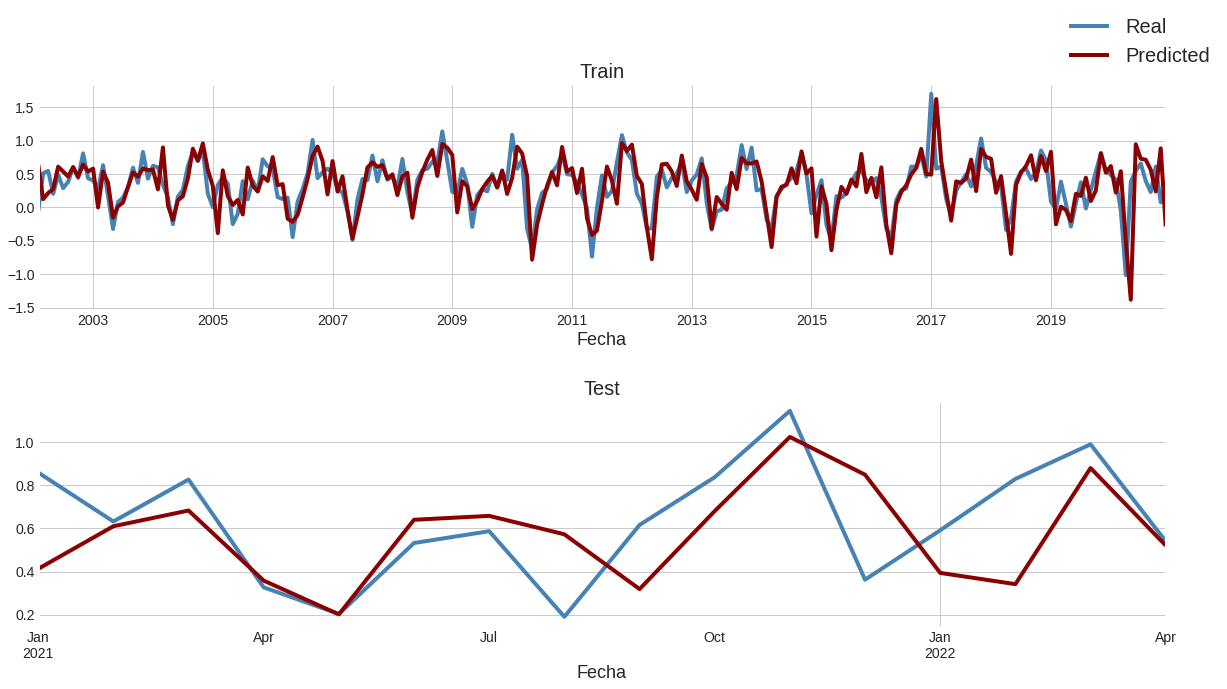

In [ ]:
data_predictions3=data[['Inflación','D(Inflación)']].copy()
data_predictions3['sarima_Dpredictions']=np.nan
data_predictions3['sarima_predictions']=np.nan


data_predictions3['sarima_Dpredictions'].iloc[13:S+1]=nn_models[14].predict(X_train).reshape(-1,)
data_predictions3['sarima_Dpredictions'].iloc[S+1:]=nn_models[14].predict(X_test).reshape(-1,)
#data_predictions3.head(20)
for i in range(data_predictions2.shape[0]-1-12):
  data_predictions3['sarima_predictions'].iloc[i+1+12]=data_predictions2['sarima_Dpredictions'].iloc[i+1+12]+data_predictions2['Inflación'].iloc[i+12]

#data_predictions3

fig,ax=plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(18)
fig.subplots_adjust(hspace=0.4)
(data_predictions3.iloc[13:S+1,[0,3]]).plot(color=['steelblue','darkred'],ax=ax[0],legend=False)
ax[0].set_title('Train',fontsize=20)
ax[0].set_xlabel('Fecha',fontsize=18)
(data_predictions3.iloc[S+1:,[0,3]]).plot(color=['steelblue','darkred'],ax=ax[1],legend=False)
ax[1].set_title('Test',fontsize=20)
ax[1].set_xlabel('Fecha',fontsize=18)
#plt.title('MSE: {:.4f}'.format(mse(test_predictions['Inflación'].values,test_predictions['Predict SARIMA'].values))
#,fontdict={'size':16})
#ax.set_xlabel('Fecha',fontdict={'size':16})
#ax.legend(['Real','Predicted'],loc='upper center',prop={'size': 20},bbox_to_anchor=(0.1, 1.1))
fig.legend(['Real','Predicted'],loc='upper right',prop={'size': 20})
plt.savefig('sarima_fore.png',dpi=100,format='png')
plt.show()

In [ ]:
print('train_mse: ',mse(data_predictions3[['Inflación']].iloc[13:S+1,:].values,data_predictions3[['sarima_predictions']].iloc[13:S+1,:].values))
print('test_mse',mse(data_predictions3[['Inflación']].iloc[S+1:,:].values,data_predictions3[['sarima_predictions']].iloc[S+1:,:].values))

train_mse:  [0.09317346]
test_mse [0.06480569]


In [ ]:
data_predictions3.iloc[13:S+1,[0,3]]